In [1]:
import sys 
sys.path.append('..')
import torch
from torch.nn.functional import one_hot
import numpy as np
import matplotlib.pyplot as plt
from random_features.polynomial_sketch import PolynomialSketch

../util/fwht/__init__.py:28: UserWarning: Including and compiling a custom C++ and CUDA (if available) extension might take a while...
  warnings.warn('Including and compiling a custom C++ and CUDA (if available) extension might take a while...', )
../util/fwht/__init__.py:31: UserWarning: CXX variable not set. Setting CXX=g++...
  warnings.warn('CXX variable not set. Setting CXX=g++...',)
../util/fwht/__init__.py:36: UserWarning: PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH
  warnings.warn('PATH variable does not include ~/.local/bin. Updating PATH=$HOME/.local/bin:$PATH')


In [2]:
import util.data

In [683]:
degree = 2
a = 2.
bias = 1.-2./a**2
lengthscale = a / np.sqrt(2.)

In [286]:
bias=0

In [84]:
lengthscale

1.414213562373095

In [684]:
train_data, train_labels = torch.load('../../datasets/export/fashion_mnist/pytorch/train_fashion_mnist.pth')
test_data, test_labels = torch.load('../../datasets/export/fashion_mnist/pytorch/test_fashion_mnist.pth')

In [478]:
train_data, train_labels = torch.load('../../datasets/export/mnist/pytorch/train_mnist.pth')
test_data, test_labels = torch.load('../../datasets/export/mnist/pytorch/test_mnist.pth')

In [470]:
train_data, train_labels = torch.load('../../datasets/export/adult/pytorch/train_adult.pth')
test_data, test_labels = torch.load('../../datasets/export/adult/pytorch/test_adult.pth')

In [110]:
train_data, train_labels = torch.load('../../datasets/export/cod-rna/pytorch/train_cod-rna.pth')
test_data, test_labels = torch.load('../../datasets/export/cod-rna/pytorch/test_cod-rna.pth')

In [587]:
train_data, train_labels = torch.load('/home/jonas/python-projects/datasets/export/cifar10/pytorch/train_cifar10_resnet34_final.pth')
test_data, test_labels = torch.load('/home/jonas/python-projects/datasets/export/cifar10/pytorch/test_cifar10_resnet34_final.pth')

In [510]:
train_data.shape

torch.Size([50000, 512])

In [133]:
test_data.shape

torch.Size([2000, 16])

In [41]:
data, labels = torch.load('../../datasets/export/eeg/pytorch/eeg.pth')
# shuffle data and labels
indices = torch.randperm(len(data))
train_data = data[indices[:int(0.9*len(data))]]
train_labels = labels[indices[:int(0.9*len(data))]]
test_data = data[int(0.9*len(data)):]
test_labels = labels[int(0.9*len(data)):]

In [217]:
data, labels = torch.load('../../datasets/export/letter/pytorch/letter.pth')
# shuffle data and labels
indices = torch.randperm(len(data))
train_data = data[indices[:int(0.9*len(data))]]
train_labels = labels[indices[:int(0.9*len(data))]]
test_data = data[int(0.9*len(data)):]
test_labels = labels[int(0.9*len(data)):]

In [685]:
train_data = train_data.reshape(len(train_data), -1)
test_data = test_data.reshape(len(test_data), -1)

In [607]:
# mean = train_data.mean(dim=0, keepdim=True)
# std = train_data.std(dim=0, keepdim=True)
# std[std==0] = 1.
# train_data = (train_data - mean) / std
# test_data = (test_data - mean) / std
# train_data = train_data / std
# test_data = test_data / std
train_data = train_data / train_data.norm(dim=1, keepdim=True)
test_data = test_data / test_data.norm(dim=1, keepdim=True)

In [686]:
indices = torch.randint(len(train_data), (1000,))
train_data = train_data[indices]
train_labels = train_labels[indices]
indices = torch.randint(len(test_data), (1000,))
test_data = test_data[indices]
test_labels = test_labels[indices]

In [687]:
# rbf kernel
median_distance = torch.cdist(train_data, train_data).median()
lengthscale = median_distance
train_data = train_data / lengthscale
test_data = test_data / lengthscale
bias = 1.

squared_norm = (train_data**2).sum(dim=1)
prefactor_train = torch.exp(-squared_norm / 2.)

train_data = train_data / np.sqrt(degree)
test_data = test_data / np.sqrt(degree)

In [655]:
lengthscale

tensor(2919.8086)

In [688]:
placeholder = torch.zeros(len(train_data), 1024)
placeholder[:, :train_data.shape[1]] = train_data #/ lengthscale
placeholder[:, train_data.shape[1]] = np.sqrt(bias)
train_data = placeholder
placeholder = torch.zeros(len(test_data), 1024)
placeholder[:, :test_data.shape[1]] = test_data #/ lengthscale
placeholder[:, test_data.shape[1]] = np.sqrt(bias)
test_data = placeholder

In [592]:
train_labels[train_labels==-1.] = 0
test_labels[test_labels==-1.] = 0
#train_labels = one_hot(train_labels.type(torch.LongTensor)).reshape(-1, 2).type(torch.FloatTensor)
#test_labels = one_hot(test_labels.type(torch.LongTensor)).reshape(-1, 2).type(torch.FloatTensor)

In [613]:
train_labels

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [689]:
def cholesky_solve(y, L):
    # L: lower triangular cholesky
    return torch.triangular_solve(
        torch.triangular_solve(y, L, upper=False)[0],
        L.conj().t(), transpose=False, upper=True
    )[0]

In [690]:
def solve_linear_regression(train_features, train_labels, test_features, lam=0.1):
    sigma_inv = train_features.t() @ train_features + torch.eye(len(train_features.t())) * lam
    xTy = train_features.t() @ train_labels
    L_sigma_inv = torch.cholesky(sigma_inv)
    alpha = cholesky_solve(xTy, L_sigma_inv)
    return test_features @ alpha

In [707]:
real_errors = []
comp_errors = []

real_accs = []
comp_accs = []

for degree in [degree]:
    print('Degree', degree)
    real_errors_cur = []
    comp_errors_cur = []
    
    real_accs_cur = []
    comp_accs_cur = []
    
    for seed in range(30):

        # real sketch
        feature_encoder = PolynomialSketch(
            1024, # data input dimension (power of 2 for srht projection_type)
            2*1024, # output dimension of the random sketch
            degree=degree, # degree of the polynomial kernel
            bias=0, # bias parameter of the polynomial kernel
            lengthscale=1., # inverse scale of the data (like lengthscale for Gaussian kernel)
            projection_type='srht',
            hierarchical=False,
            complex_weights=False,
            full_cov=False
        )

        feature_encoder.resample()
        projections_train = feature_encoder.forward(train_data)
        projections_test = feature_encoder.forward(test_data)
        approx_kernel_real = projections_train @ projections_train.t()
        predictions_real = solve_linear_regression(projections_train, train_labels, projections_test, lam=0.1)
#         projections_train = feature_encoder.forward(train_data)
#         projections_test = feature_encoder.forward(test_data)
#         projections_train = torch.hstack([projections_train.real, projections_train.imag])
#         projections_test = torch.hstack([projections_test.real, projections_test.imag])
        
#         predictions_real = solve_linear_regression(projections_train, train_labels, projections_test, lam=0.1)
#         approx_kernel_real = projections_train @ projections_train.t()

        # complex sketch
        feature_encoder = PolynomialSketch(
            1024, # data input dimension (power of 2 for srht projection_type)
            1*1024, # output dimension of the random sketch
            degree=degree, # degree of the polynomial kernel
            bias=0, # bias parameter of the polynomial kernel
            lengthscale=1., # inverse scale of the data (like lengthscale for Gaussian kernel)
            projection_type='srht',
            hierarchical=False,
            complex_weights=True,
            full_cov=True
        )

        feature_encoder.resample()
        projections_train = feature_encoder.forward(train_data)
        projections_test = feature_encoder.forward(test_data)
        projections_train = torch.hstack([projections_train.real, projections_train.imag])
        projections_test = torch.hstack([projections_test.real, projections_test.imag])
        
        predictions_comp = solve_linear_regression(projections_train, train_labels, projections_test, lam=0.1)
        approx_kernel_comp = projections_train @ projections_train.t()
#         projections_train = feature_encoder.forward(train_data)
#         projections_test = feature_encoder.forward(test_data)
#         approx_kernel_comp = projections_train @ projections_train.t()
#         predictions_comp = solve_linear_regression(projections_train, train_labels, projections_test, lam=0.1)

        # reference kernel
        # ref_kernel = (train_data @ train_data.t())**degree
        pref = prefactor_train.unsqueeze(1) * prefactor_train.unsqueeze(0)
        ref_kernel = pref * (train_data @ train_data.t())**degree
        approx_kernel_comp *= pref
        approx_kernel_real *= pref

        # error
        real_error = (approx_kernel_real - ref_kernel).pow(2).sum().sqrt()
        real_error /= ref_kernel.pow(2).sum().sqrt()

        comp_error = (approx_kernel_comp - ref_kernel).pow(2).sum().sqrt()
        comp_error /= ref_kernel.pow(2).sum().sqrt()

        real_errors_cur.append(real_error.item())
        comp_errors_cur.append(comp_error.item())
        
        real_acc = (predictions_real.argmax(dim=1) == test_labels.argmax(dim=1)).sum() / len(test_labels)
        comp_acc = (predictions_comp.argmax(dim=1) == test_labels.argmax(dim=1)).sum() / len(test_labels)
        
        real_accs_cur.append(real_acc.item())
        comp_accs_cur.append(comp_acc.item())
        
    real_errors.append(np.array(real_errors_cur))
    comp_errors.append(np.array(comp_errors_cur))
    
    real_accs.append(np.array(real_accs_cur))
    comp_accs.append(np.array(comp_accs_cur))

Degree 2


In [708]:
approx_kernel_real

tensor([[0.8274, 0.6083, 0.6718,  ..., 0.7062, 0.5640, 0.5103],
        [0.6083, 0.7346, 0.6144,  ..., 0.7040, 0.5240, 0.4842],
        [0.6718, 0.6144, 0.8003,  ..., 0.6887, 0.5200, 0.4811],
        ...,
        [0.7062, 0.7040, 0.6887,  ..., 0.8849, 0.6438, 0.5969],
        [0.5640, 0.5240, 0.5200,  ..., 0.6438, 0.8794, 0.5912],
        [0.5103, 0.4842, 0.4811,  ..., 0.5969, 0.5912, 0.7708]])

In [709]:
approx_kernel_comp

tensor([[0.8299, 0.5975, 0.6743,  ..., 0.6933, 0.5325, 0.4697],
        [0.5975, 0.7434, 0.6026,  ..., 0.7065, 0.5181, 0.4679],
        [0.6743, 0.6026, 0.7992,  ..., 0.6750, 0.4992, 0.4527],
        ...,
        [0.6933, 0.7065, 0.6750,  ..., 0.8732, 0.6283, 0.5712],
        [0.5325, 0.5181, 0.4992,  ..., 0.6283, 0.8357, 0.5560],
        [0.4697, 0.4679, 0.4527,  ..., 0.5712, 0.5560, 0.7334]])

In [710]:
ref_kernel

tensor([[0.8535, 0.6079, 0.6891,  ..., 0.7108, 0.5494, 0.4957],
        [0.6079, 0.7305, 0.6017,  ..., 0.7035, 0.5231, 0.4734],
        [0.6891, 0.6017, 0.8020,  ..., 0.6774, 0.5157, 0.4683],
        ...,
        [0.7108, 0.7035, 0.6774,  ..., 0.8833, 0.6361, 0.5836],
        [0.5494, 0.5231, 0.5157,  ..., 0.6361, 0.8565, 0.5699],
        [0.4957, 0.4734, 0.4683,  ..., 0.5836, 0.5699, 0.7409]])

In [711]:
np.mean(np.array(real_errors), axis=1)

array([0.02277108])

In [712]:
np.mean(np.array(comp_errors), axis=1)

array([0.01805095])

In [713]:
np.mean(np.array(real_accs), axis=1)

array([0.8002])

In [714]:
np.mean(np.array(comp_accs), axis=1)

array([0.80000001])

In [173]:
def var_real(X, p=1):
    # sum(x_i y_i)
    dot_product = X @ X.t()
    # sum(x_i^2 y_i^2)
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    # ||x||^2 ||y||^2
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    moment_real = (norms_squared + 2 * (dot_product**2 - squared_dot_product))
    
    return 0.5*(moment_real**p - dot_product**(2*p))

In [174]:
def var_difference(X, p=1):
    # sum(x_i y_i)
    dot_product = X @ X.t()
    # sum(x_i^2 y_i^2)
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    # ||x||^2 ||y||^2
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    moment_real = (norms_squared + 2 * (dot_product**2 - squared_dot_product))
    moment_comp_abs = (norms_squared + dot_product**2 - squared_dot_product)
    moment_comp_re = (2 * dot_product**2 - squared_dot_product)
    
    var_dif = 0.5*(moment_real**p - moment_comp_abs**p - moment_comp_re**p + dot_product**(2*p))
    
    return var_dif

In [175]:
def power_diff(X, p=1):
    dot_product = X @ X.t()
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    A = (norms_squared + dot_product**2 - squared_dot_product)**p
    A -= (norms_squared**p + dot_product**(2*p) - squared_dot_product**p)
    
    return A

In [176]:
import scipy.special

In [177]:
def var_difference_2(X, p=1.):
    dot_product = X @ X.t()
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    A = 0
    
    for j in range(p+1):
        A += scipy.special.binom(p, j) * (dot_product**2 - squared_dot_product)**(p-j) \
                * power_diff(X, j)
        
    return 0.5 * A

In [178]:
def cov_difference(X, p=2., D=100):
    dot_product = X @ X.t()
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    d = X.shape[1]
    num_non_zero_pairs = lambda x: (np.floor(x / d)*d*(d-1) + (x % d) * (x % d - 1)) / x**2
    
    A = (dot_product**2 - (1./(d-1.)) * (norms_squared + dot_product**2 - 2.*squared_dot_product))
    B = (dot_product**2 - (1./(d-1.)) * (norms_squared - squared_dot_product))
    C = (dot_product**2 - (1./(d-1.)) * (dot_product**2 - squared_dot_product))
    
    comp_real_cov = 0.5 * num_non_zero_pairs(D) * (B + C - 2.*dot_product**(2*p))
    real_cov = num_non_zero_pairs(2.*D) * (A - dot_product**(2*p))
    
    return real_cov - comp_real_cov

In [179]:
def var_cov_difference(X, p=2., D=100):
    return var_difference(X, p) / D + cov_difference(X, p, D)

In [180]:
X = train_data

In [182]:
var_cov_difference(X, p=20, D=2*X.shape[1]).sum()

tensor(-124330.0391)

In [181]:
(var_cov_difference(X, p=20, D=2*X.shape[1]) > 0).sum().item() / len(X)**2 *100

11.3454

In [115]:
var_cov_difference(X, p=20, D=4*X.shape[1])

tensor([[ 2.8931e+05, -2.0480e-03, -2.1660e-05,  ..., -7.0010e-04,
         -3.3333e-03, -1.0663e-02],
        [-2.0480e-03,  3.7594e+05, -4.4267e-05,  ..., -1.1708e-03,
         -7.0176e-03, -4.1551e-03],
        [-2.1660e-05, -4.4267e-05,  2.8788e+04,  ..., -1.2180e-04,
         -5.2765e-04, -1.1489e-04],
        ...,
        [-7.0010e-04, -1.1708e-03, -1.2180e-04,  ...,  2.3981e+05,
         -2.0139e-05, -9.9734e-04],
        [-3.3333e-03, -7.0176e-03, -5.2765e-04,  ..., -2.0139e-05,
          3.6512e+05, -5.4124e-03],
        [-1.0663e-02, -4.1551e-03, -1.1489e-04,  ..., -9.9734e-04,
         -5.4124e-03,  2.7851e+05]])

In [71]:
X.shape[1]

1024

In [89]:
X.norm(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [70]:
(var_difference(X, p=4) > 0).sum().item() / len(X)**2

1.0

In [82]:
(cov_difference(X, p=2, D=128) < 0).sum()

tensor(278006)

In [75]:
(cov_difference(X, p=3) > 0).sum()

tensor(923088)

In [57]:
cov_difference(X, p=10)

tensor([[4.4852e-05, 2.5774e-07, 2.4540e-07,  ..., 2.4959e-07, 3.0268e-07,
         2.6799e-07],
        [2.5774e-07, 4.4584e-05, 1.5483e-07,  ..., 2.9150e-07, 3.2177e-07,
         2.9104e-07],
        [2.4540e-07, 1.5483e-07, 4.4584e-05,  ..., 2.2189e-07, 4.0163e-07,
         2.7078e-07],
        ...,
        [2.5053e-07, 2.9127e-07, 2.2189e-07,  ..., 4.4286e-05, 2.9779e-07,
         3.2550e-07],
        [3.0361e-07, 3.2061e-07, 4.0000e-07,  ..., 2.9779e-07, 4.4554e-05,
         2.6543e-07],
        [2.6706e-07, 2.9104e-07, 2.7008e-07,  ..., 3.2550e-07, 2.6543e-07,
         4.4286e-05]])

In [36]:
cov_difference(X, p=3)[cov_difference(X, p=3) > 0]

tensor([0.0735, 0.0170, 0.0711,  ..., 0.0321, 0.0489, 0.0872])

In [23]:
cov_difference(train_data, p=2)

tensor([[       0.,        0.,        0.,  ...,        0.,        0.,
                0.],
        [       0.,        0.,   -65536.,  ...,        0.,        0.,
                0.],
        [       0.,   -65536.,   262144.,  ...,        0.,        0.,
         -1048576.],
        ...,
        [       0.,        0.,        0.,  ...,        0.,  -524288.,
          4194304.],
        [       0.,        0.,        0.,  ...,  -524288.,  2097152.,
                0.],
        [       0.,        0., -1048576.,  ...,  4194304.,        0.,
                0.]])

In [66]:
var_difference(train_data, p=10)

tensor([[2.8062e+04, 9.8500e+03, 6.7743e+03,  ..., 2.0645e+00, 4.6159e+02,
         3.2826e+00],
        [9.8500e+03, 2.7974e+04, 2.5104e+03,  ..., 1.4304e+00, 1.4148e+02,
         2.2877e+00],
        [6.7743e+03, 2.5104e+03, 2.8001e+04,  ..., 1.3051e+00, 1.0197e+03,
         2.2019e+00],
        ...,
        [2.0645e+00, 1.4304e+00, 1.3051e+00,  ..., 2.5166e+04, 3.0383e-01,
         5.0348e+02],
        [4.6159e+02, 1.4148e+02, 1.0197e+03,  ..., 3.0383e-01, 2.7667e+04,
         7.0342e-01],
        [3.2826e+00, 2.2877e+00, 2.2019e+00,  ..., 5.0348e+02, 7.0342e-01,
         2.6037e+04]])

In [65]:
var_difference_2(train_data, p=10)

tensor([[2.8062e+04, 9.8500e+03, 6.7743e+03,  ..., 2.0645e+00, 4.6159e+02,
         3.2827e+00],
        [9.8500e+03, 2.7974e+04, 2.5104e+03,  ..., 1.4304e+00, 1.4148e+02,
         2.2877e+00],
        [6.7743e+03, 2.5104e+03, 2.8001e+04,  ..., 1.3051e+00, 1.0197e+03,
         2.2019e+00],
        ...,
        [2.0645e+00, 1.4304e+00, 1.3051e+00,  ..., 2.5166e+04, 3.0383e-01,
         5.0348e+02],
        [4.6159e+02, 1.4148e+02, 1.0197e+03,  ..., 3.0383e-01, 2.7667e+04,
         7.0342e-01],
        [3.2826e+00, 2.2877e+00, 2.2019e+00,  ..., 5.0348e+02, 7.0342e-01,
         2.6037e+04]])

In [36]:
def power_diff_2(X, p=1):
    dot_product = X @ X.t()
    squared_dot_product = X.pow(2) @ X.pow(2).t()
    norms_squared = (X**2).sum(dim=1).unsqueeze(1) * (X**2).sum(dim=1).unsqueeze(0)
    
    A = 0
    
    for j in range(p):
        A += scipy.special.binom(p, j) * (norms_squared**j - squared_dot_product**j) \
                * (dot_product**2 - squared_dot_product)**(p-j)
    
    return A

In [49]:
power_diff(train_data, p=4)

tensor([[13.9263, 10.1529,  9.0634,  ...,  0.4979,  3.9424,  0.6246],
        [10.1529, 13.9114,  6.6938,  ...,  0.4111,  2.6803,  0.5243],
        [ 9.0634,  6.6938, 13.9161,  ...,  0.3911,  5.0634,  0.5143],
        ...,
        [ 0.4979,  0.4111,  0.3911,  ..., 13.4198,  0.1571,  4.0494],
        [ 3.9424,  2.6803,  5.0634,  ...,  0.1571, 13.8594,  0.2736],
        [ 0.6246,  0.5243,  0.5143,  ...,  4.0494,  0.2736, 13.5761]])

In [50]:
power_diff_2(train_data, p=4)

tensor([[13.9263, 10.1529,  9.0634,  ...,  0.4979,  3.9424,  0.6246],
        [10.1529, 13.9114,  6.6938,  ...,  0.4111,  2.6803,  0.5243],
        [ 9.0634,  6.6938, 13.9161,  ...,  0.3911,  5.0634,  0.5143],
        ...,
        [ 0.4979,  0.4111,  0.3911,  ..., 13.4198,  0.1571,  4.0494],
        [ 3.9424,  2.6803,  5.0634,  ...,  0.1571, 13.8594,  0.2736],
        [ 0.6246,  0.5243,  0.5143,  ...,  4.0494,  0.2736, 13.5761]])

In [32]:
for p in range(1, 10):
    print((power_diff(train_data, p=p) > 0).sum() / len(train_data)**2)

tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)


In [39]:
X = torch.rand(1000, 16)
# X = X / X.norm(dim=1, keepdim=True)
#X[:len(X)//2]*=10

In [42]:
X = train_data.reshape(len(train_data), -1)

In [52]:
(var_difference(X, 1) < 0).sum() / len(X)**2

tensor(0.4504)

In [53]:
(var_difference(X, 2) < 0).sum() / len(X)**2

tensor(0.)

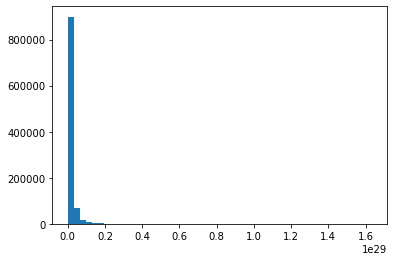

In [54]:
plt.hist(var_real(X, 2).view(-1).numpy(), bins=50)
plt.show()

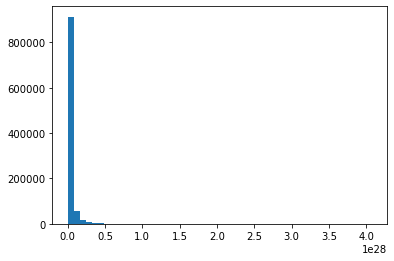

In [55]:
plt.hist(var_difference(X, 2).view(-1).numpy(), bins=50)
plt.show()

In [56]:
(var_difference(X, 3) < 0).sum() / len(X)**2

tensor(0.)

ValueError: supplied range of [1.347085896850571e+37, inf] is not finite

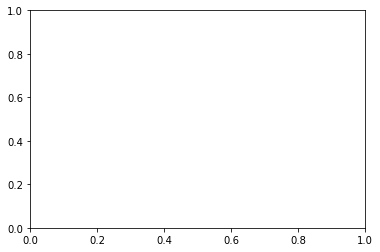

In [57]:
plt.hist(var_real(X, 3).view(-1).numpy(), bins=50)
plt.show()

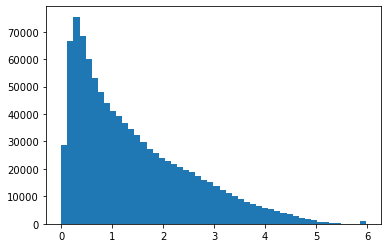

In [41]:
plt.hist(var_difference(X, 3).view(-1).numpy(), bins=50)
plt.show()

In [58]:
(var_difference(X, 4) < 0).sum() / len(X)**2

tensor(0.)

/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6721: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/jonas/anaconda3/envs/deep_avx/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6722: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

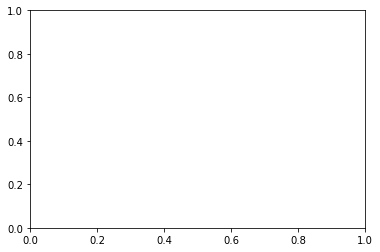

In [59]:
plt.hist(var_real(X, 4).view(-1).numpy(), bins=50)
plt.show()

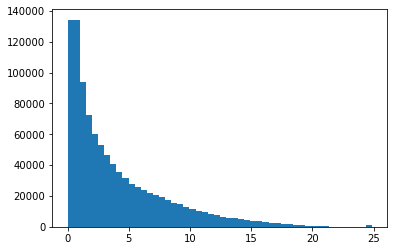

In [44]:
plt.hist(var_difference(X, 4).view(-1).numpy(), bins=50)
plt.show()